## Expectation Reflection for Classification

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
l = 500
n = 100
g = 6.

###  Discrete variables

In [4]:
def synthesize_data(l,n,g,data_type='discrete'):
    w = np.random.normal(0.,g/np.sqrt(n),size=n)
    
    if data_type == 'binary':
        X = np.sign(np.random.rand(l,n)-0.5)
    if data_type == 'discrete':
        X = 2*np.random.rand(l,n)-1
        
    h = X.dot(w)
    p = 1/(1+np.exp(-2*h)) # kinetic
    #p = 1/(1+np.exp(-h))  # logistic regression
    y = np.sign(p - np.random.rand(l))
    return w,X,y

In [5]:
w0,X,y = synthesize_data(l,n,g,data_type='discrete')

In [6]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [7]:
h0,w = ER.fit(X,y,niter_max=100,regu=0.005)

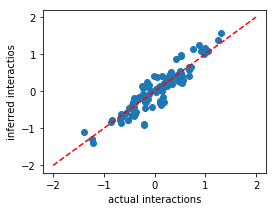

In [8]:
plt.figure(figsize=(4,3))

plt.plot([-2,2],[-2,2],'r--')
plt.scatter(w0,w)
plt.xlabel('actual interactions')
plt.ylabel('inferred interactios')

plt.show()

In [9]:
y_pred = ER.predict(X,h0,w)
accuracy = accuracy_score(y,y_pred)
mse = ((w0-w)**2).mean()
print(mse,accuracy)

(0.05324147852230975, 0.96)


In [10]:
kf = 5
def ER_inference(X,y,kf=5,regu=0.005):    
    #x_train,x_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state = 100)    
    kfold = KFold(n_splits=kf,shuffle=False,random_state=1)
    accuracy = np.zeros(kf)
    
    for i,(train_index,test_index) in enumerate(kfold.split(y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # predict with ER
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.005)
        y_pred = ER.predict(X_test,h0,w)
        accuracy[i] = accuracy_score(y_test,y_pred)
        #print(accuracy[i])
    return accuracy.mean(),accuracy.std()

In [11]:
regu_list = [0.0,0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.1,0.2,0.5,0.6,0.8,1.]
for regu in regu_list:
    accuracy_mean,accuracy_std = ER_inference(X,y,kf,regu)
    print('ER:',accuracy_mean,accuracy_std,regu)

('ER:', 0.8540000000000001, 0.01959591794226544, 0.0)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.001)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.002)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.003)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.004)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.005)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.01)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.02)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.1)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.2)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.5)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.6)
('ER:', 0.8540000000000001, 0.01959591794226544, 0.8)
('ER:', 0.8540000000000001, 0.01959591794226544, 1.0)


#### Logistic Regression

In [12]:
model = LogisticRegression(solver='liblinear')
model.fit(X, y)
w_lg = 0.5*model.coef_

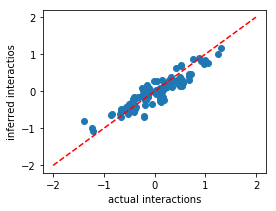

In [13]:
plt.figure(figsize=(4,3))

plt.plot([-2,2],[-2,2],'r--')
plt.scatter(w0,w_lg)
plt.xlabel('actual interactions')
plt.ylabel('inferred interactios')

plt.show()

In [14]:
y_pred = model.predict(X)
accuracy = accuracy_score(y,y_pred)
mse = ((w0-w_lg)**2).mean()
print(mse,accuracy)

(0.04385573771040335, 0.962)


In [15]:
def inference(X,y,kf=5,method='naive_bayes'):     
    kfold = KFold(n_splits=kf,shuffle=False,random_state=1)            
    accuracy = np.zeros(kf)
            
    if method == 'logistic_regression':
        model = LogisticRegression(solver='liblinear')

    if method == 'naive_bayes': 
        model = GaussianNB()
        
    if method == 'random_forest':
        model = RandomForestClassifier(criterion = "gini", random_state = 1,
                               max_depth=3, min_samples_leaf=5,n_estimators=100)        
    if method == 'decision_tree':
        model = DecisionTreeClassifier()
        
    if method == 'knn':    
        model = KNeighborsClassifier()
        
    if method == 'svm':    
        model = SVC(gamma='scale')     
        
    for i,(train_index,test_index) in enumerate(kfold.split(y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy[i] = accuracy_score(y_test,y_pred)
        #print(accuracy[i])
    return accuracy.mean(),accuracy.std()

In [16]:
other_methods=['logistic_regression']

for i,method in enumerate(other_methods):
    accuracy_mean,accuracy_std = inference(X,y,kf,method)
    print('% 20s :'%method,accuracy_mean,accuracy_std)

(' logistic_regression :', 0.8539999999999999, 0.025768197453450235)
